### PDF Display

In [1]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

# Specification in Omega
Following is the result of writing the specifications using the omega toolbox.

In [2]:
from omega.games import gr1
from omega.games import enumeration as enum
from omega.symbolic import temporal as trl
from omega.games.enumeration import action_to_steps
from omega.symbolic import enumeration as sym_enum
import networkx as nx

In [3]:
aut = trl.Automaton()
MAX_ROOMS = 2
aut.declare_variables(active=(1,MAX_ROOMS), home = (0,1),known_room=(0, MAX_ROOMS), pos=(0, MAX_ROOMS), known=(0,1))
aut.varlist['env']=['active']
aut.varlist['sys']=['known_room','known','pos','home']
aut.prime_varlists()

In [4]:
aut.init['env'] = '''
    /\ active = 1
    '''

aut.action['env'] = '''
    /\ active \in 1..2
    /\ active' \in 1..2
    /\ (active' = active \/ active' != active)
'''

In [5]:
aut.init['sys'] = '''
    /\ pos = 0
    /\ home = 1
    /\ known_room = 0
    /\ known = 0
    '''

aut.action['sys'] = '''
    /\ (home = 1 => home' = 0)
    /\ (home = 1 <=> pos = 0)
    /\ (~(home = 0 /\ known' = 1) \/ home' = 1)
    /\ (pos' != pos)

    /\ (~(home = 0 /\ pos = 1 /\ active = 1) \/ (known' = 1 /\ known_room' = 1))
    /\ (~(home = 0 /\ pos = 2 /\ active = 2) \/ (known' = 1 /\ known_room' = 2))

    /\ (~(home = 1 /\ known = 1 /\ known_room = 1) \/ (known' = 1 /\ known_room' = 1 /\ pos' = 1))
    /\ (~(home = 1 /\ known = 1 /\ known_room = 2) \/ (known' = 1 /\ known_room' = 2 /\ pos' = 2))

    /\ (~(home = 0 /\ (pos = 2 /\ active != 2)) \/ (known' = 0 /\ known_room' = 0 /\ pos' = 1))
    /\ (~(home = 0 /\ (pos = 1 /\ active != 1)) \/ (known' = 0 /\ known_room' = 0 /\ pos' = 2))
    '''

In [6]:
aut.win['<>[]'] = aut.bdds_from('active=1 \/ active=2')
aut.win['[]<>'] = aut.bdds_from('active=1 \/ active=2')

In [7]:
aut.qinit = '\E \A'
aut.moore = True
aut.plus_one = True

z, yij, xijk = gr1.solve_streett_game(aut)
gr1.make_streett_transducer(z, yij, xijk, aut)
aut.varlist['sys'].append('_goal')
aut.prime_varlists()

g = enum.action_to_steps(aut, 'env', 'impl', qinit=aut.qinit)
h, _ = sym_enum._format_nx(g)
pd = nx.drawing.nx_pydot.to_pydot(h)
pd.write_pdf('game_states_omega.pdf')
PDF('game_states_omega.pdf',size=(900,900))

# Specification in TuLiP
Following is the result of writing the specifications using the TuLiP toolbox. It is scalable w.r.t. to number of rooms.

In [8]:
from tulip import transys, spec, synth
from tulip.transys import machines

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [9]:
ROOMS = 2

env_vars = set()
env_init = set()
env_safe = set()
env_prog = set()

if ROOMS>2:
    text = ""
    for i in range(1,ROOMS+1):
        env_vars.add("active{roomN}".format(roomN=i))
        
        if i==1:
            env_init.add("active{roomN}".format(roomN=i))
        else:
            env_init.add("!active{roomN}".format(roomN=i))

        ands = ' && '
        text = text + "( active{roomN} && ".format(roomN=i)
        for j in range(1,ROOMS+1):
            if j==i:
                continue
            text = text + "!active{roomN}".format(roomN=j)
            text = text + ands
        text = text[0:-4] + " ) || "
        env_prog.add("active{roomN}".format(roomN=i))
    env_safe.add(text[0:-4])
else:
    env_vars = {'active1','active2'}
    env_init = {'active1','!active2'}
    env_safe = {'active1 <-> !active2'}
    env_prog = {'active1','active2'}

In [10]:
sys_vars = {'room':(0,ROOMS),'known_room':(0,ROOMS),'home':"boolean",'known':"boolean"}
sys_init = {'home', 'room = 0', '!known', 'known_room = 0'}
sys_safe = {
    'home -> X (!home)',
    'home <-> room = 0',
    '!home && X known -> X home'
}

for i in range(1,ROOMS+1):
    line1 = '!home && room = {roomN} && active{roomN} -> X (known && known_room = {roomN})'.format(roomN=i)
    line2 = 'home && known && known_room = {roomN} -> X (known && known_room = {roomN} && room = {roomN})'.format(roomN=i)
    if i<ROOMS:
        line3 = '!home && (room = {roomN} && !active{roomN}) -> X (!known && known_room = 0 && room = {NroomN})'.format(roomN=i,NroomN=i+1)
    else:
        line3 = '!home && (room = {roomN} && !active{roomN}) -> X (!known && known_room = 0 && room = {NroomN})'.format(roomN=i,NroomN=1)
    sys_safe.add(line1)
    sys_safe.add(line2)
    sys_safe.add(line3)

sys_prog = set()

In [21]:
specs = spec.GRSpec(env_vars = env_vars, env_init = env_init, env_safety = env_safe, env_prog = env_prog,
                    sys_vars = sys_vars, sys_init = sys_init, sys_safety = sys_safe, sys_prog = sys_prog)

# print(specs.dumps())

specs.moore = True
specs.qinit = '\E \A'  # i.e., "there exist sys_vars: forall sys_vars"

strategy = synth.synthesize(specs)
assert strategy is not None, 'unrealizable'
if not strategy.save('game_states_tulip.pdf'):
    print('Done')
#     print(strategy)

# simulate
# print(strategy)
# machines.random_run(strategy, N=10)
PDF('game_states_tulip.pdf',size=(900,900))

removed 12 nodes from 26 total


# Simulations

##  with Omega

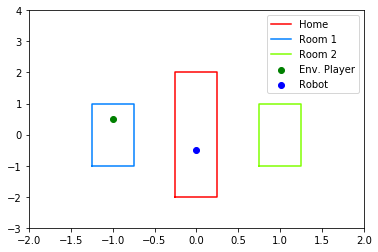

Environment's next step is: 0
Robot goes to: 0


In [20]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

active = 1
activeR = -1
room = 0
roomR = 0
current = 0
run = True  #set active == 0 to exit loop
while run:
    plt.axis([-2,2,-3,4])
    plt.plot([-.25,.25,.25,-.25,-.25],[-2,-2,2,2,-2],c='red')
    plt.plot([-1.25,-.75,-.75,-1.25,-1.25],[-1,-1,1,1,-1],c=(0,0.5,1))
    plt.plot([.75,1.25,1.25,.75,.75],[-1,-1,1,1,-1],c=(0.5,1,0))

    # environment
    plt.scatter([activeR],[0.5],c='green')
    # system
    plt.scatter([roomR],[-.5],c='blue')
    plt.legend(['Home','Room 1','Room 2','Env. Player','Robot'])
    plt.show()
    # environment input
    active = int(input("Environment's next step is: "))
    plt.close()
    successors = list(g._succ[current].keys())
    
    if active == 1:
        activeR = -1
        for suc in successors:
            if g._node.get(suc)['active'] == 1:
                current = suc
    elif active == 2:
        activeR = 1
        for suc in successors:
            if g._node.get(suc)['active'] == 2:
                current = suc
    elif active == 0:   #set active == 0 to exit loop
        run = False
    room = g._node.get(current)['pos']
    print("Robot goes to: {}".format(room))
    if room == 0:
        roomR = 0
    elif room == 1:
        roomR = -1
    elif room == 2:
        roomR = 1
    time.sleep(3)
    clear_output(wait=True)